# Multi-class Classification and Neural Networks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io  # Used to load the OCTAVE *.mat files

import scipy.misc                # Used to show matrix as an image
import matplotlib.cm as cm       # Used to display images in a specific colormap
import random
from scipy.special import expit  # Vectorized sigmoid function

## Visualize the data

In [2]:
def ndarray_description(x):
    return "shape: {}, min: {}, max: {}".format(x.shape, x.min(), x.max())

In [3]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']

# insert column of ones
X = np.insert(X, 0, 1, axis=1)

print("X dimensions:", X.shape)  # 5000 images with 400 pixels (20x20)
print("y dimensions:", y.shape)  # Labeled classification 1-10, 10 represents 0

X dimensions: (5000, 401)
y dimensions: (5000, 1)


In [4]:
print("X", ndarray_description(X))
print("y", ndarray_description(y))

X shape: (5000, 401), min: -0.13196323019852488, max: 1.127688299158888
y shape: (5000, 1), min: 1, max: 10


(-0.5, 399.5, 19.5, -0.5)

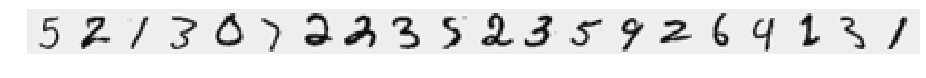

In [5]:
sample = np.random.choice(X.shape[0], 20)  # 20 row indices from X

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(X[sample, 1:].reshape(-1,20).T, cmap='gray_r')  # 0 index is 1 constant
ax.axis('off')

## Multi-class Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [6]:
def hypothesis(theta, X):
    """Vectorized computation of the hypothesis for each example X with a set of theta values.
    
    X dot-product theta takes 401 x(i) values in a row of X (a vector) and
    multiples them with the 401 theta vector values. A.t * B = B.t * A if both are 
    vectors, so this vectorizes the g(theta.t * x) logistic hypothesis for all 5000
    examples in X.
    
    :param numpy.ndarray theta: 401x1 vector of theta values
    :param numpy.ndarray X: 5000x401 matrix of examples
    
    :returns: 5000x1 array
    :rtype: numpy.ndarray
    """
    return expit(np.dot(X, theta))

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [7]:
initial_theta = np.random.uniform(X.min(), X.max(), (X.shape[1], 1))  # 401x1
print("initial_theta", ndarray_description(initial_theta))

initial_theta shape: (401, 1), min: -0.1298930691775699, max: 1.126711348867077


In [8]:
h = hypothesis(initial_theta, X)  # 5000x1
print("h", ndarray_description(h))

h shape: (5000, 1), min: 0.9990260622303396, max: 1.0


In [41]:
def cost(theta, X, y, learning_rate=0.): 
    """Calculate the total cost for every example with a set of parameter values.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of parameter values (401x1)
    :param numpy.ndarray X: An array of examples with n columns and m rows (5000x401)
    :param numpy.ndarray y: The labeled prediction vector, m rows and 1 column (5000x1)
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :rtype: numpy.float64
    """
    m = X.shape[0]            # 5000
    h = hypothesis(theta, X)  # 5000x1 vector
    
    # use dot product to sum all terms in y * log(h) vectors
    term1 = np.log(h).T.dot(-1*y)   # scalar
    term2 = np.log(1-h).T.dot(1-y)  # scalar
    reg = (learning_rate/(2*m)) * np.sum(np.square(theta[1:]))  # scalar, exclude theta[0]
    
    J = (1/m)*(term1-term2) + reg  # still 1x1 vectors
    return J[0]

In [43]:
J = cost(initial_theta, X, y)
print("Initial cost:", J)

Initial cost: 160.39425758157174


#### Regularized Gradient

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [75]:
def cost_gradient(theta, X, y, learning_rate=0.):
    """Calculate the gradient for every theta value with a set of parameter values.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of parameter values (401x1)
    :param numpy.ndarray X: An array of examples with n columns and m rows (5000x401)
    :param numpy.ndarray y: The labeled prediction vector, m rows and 1 column (5000x1)
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :returns: 401x5000 array
    :rtype: numpy.ndarray
    """
    m = X.shape[0]                          # 5000
    h = hypothesis(theta, X).reshape(-1,1)  # 5000x1 vector
    
    beta = h - y
    grad = (1/m) * X.T.dot(beta)                       # 401x1
    
    reg = ((1.0/m) * initial_theta[1:]).reshape(-1,1)  # 400x1
    reg = np.insert(reg, 0, 0).reshape(-1,1)  # insert a 0 for theta[0]
    
    return grad+reg  # 401x1

In [74]:
m = X.shape[0]                  # 5000
h = hypothesis(initial_theta, X)  # 5000x1 vector

beta = h.reshape(-1,1) - y                         # 5000x1
grad = (1/m) * X.T.dot(beta)                       # 401x1
reg = ((1.0/m) * initial_theta[1:]).reshape(-1,1)  # 400x1
reg = np.insert(reg, 0, 1).reshape(-1,1)
reg.shape
# res = grad+reg.reshape(-1,1)
# res.shape

(401, 1)

In [76]:
g = cost_gradient(initial_theta, X, y)
g.shape

(401, 1)

In [15]:
print("initial_theta", ndarray_description(initial_theta))
print("X", ndarray_description(X))
print("y", ndarray_description(y))

initial_theta shape: (401, 1), min: -0.1298930691775699, max: 1.126711348867077
X shape: (5000, 401), min: -0.13196323019852488, max: 1.127688299158888
y shape: (5000, 1), min: 1, max: 10


In [20]:
beta = hypothesis(initial_theta, X) - y.T
print("beta", ndarray_description(beta))


beta shape: (1, 5000), min: -9.5, max: -0.5


In [17]:
from scipy import optimize

def optimize_theta(theta, X, y, learning_rate=0.):
    result = optimize.fmin_cg(cost, fprime=cost_gradient, x0=theta,
                              args=(X, y, learning_rate), maxiter=50, disp=False, full_output=True)
    return result[0], result[1]

In [18]:
optimize_theta(initial_theta, X, y)

ValueError: shapes (401,5000) and (1,5000) not aligned: 5000 (dim 1) != 1 (dim 0)